##### Image dataset: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset?resource=download
##### Metainfo csv: https://github.com/lgreski/pokemonData/blob/master/Pokemon.csv
##### You can speed up model inference on colab by changing Hardware accelerator in runtime type to any GPU option

In [4]:
!pip install datasets transformers numpy pandas Pillow matplotlib 
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git

!pip install plotly umap-learn

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/h5/8yxp_kmx1wn66zrygjd28qcw0000gn/T/pip-req-build-hxh2awnr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/h5/8yxp_kmx1wn66zrygjd28qcw0000gn/T/pip-req-build-hxh2awnr
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 842.4 kB/s eta 0:00:000:00:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=14d161c2d14d2a2205093ecd6725dddfc17459154ea41962b733e572abd05460
  Stored in directory: /private/var/folders/h5/8yxp_kmx1wn66zrygjd28qcw0000gn/T/pip-ephem-wheel-cache-2ajobzvp/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5
  Attempting uninstall: clip
    Found existing installation: clip 0.2.0
    Uninstalling clip-0.2.0:
      Successfully uninstalled clip-0.2.0


In [1]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [2]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, 
# else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [3]:
# Load Pokedex and CLIP model
pokedex = construct_pokedex()
model, preprocess, device = load_clip_model()

# Precompute Pokémon image embeddings
image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"].tolist(), device)

# Precompute Pokémon type embeddings
pokedex['type'] = pokedex['Type1']+' '+pokedex['Type2']
type_embeddings = clip_inference_text(model, preprocess, pokedex['type'].tolist(), device)


### Question 26

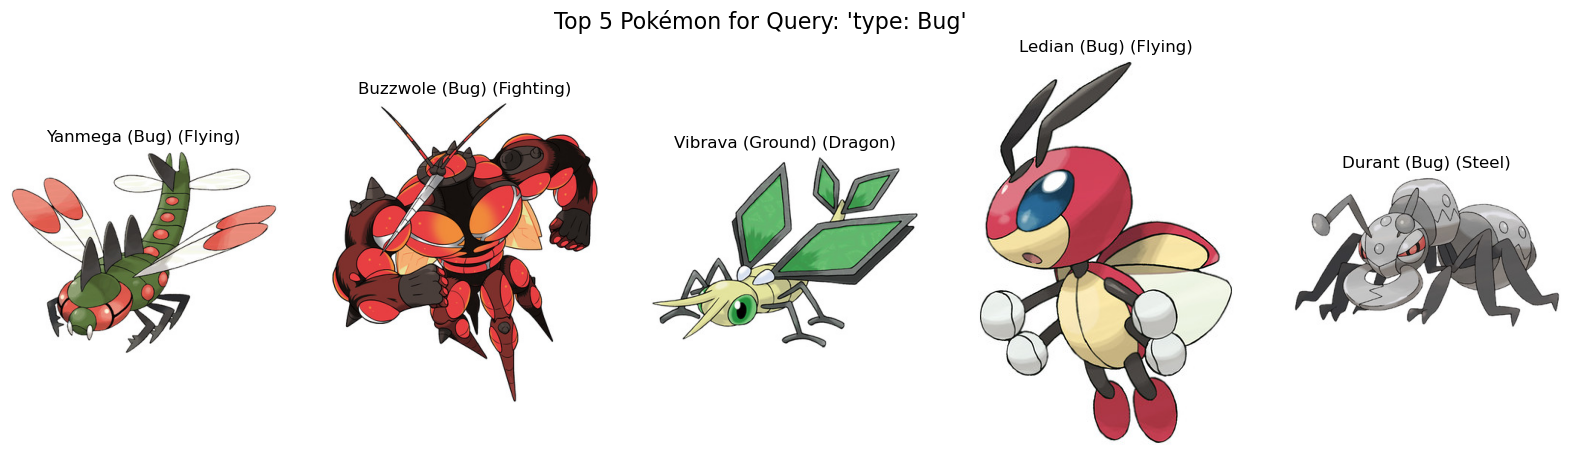

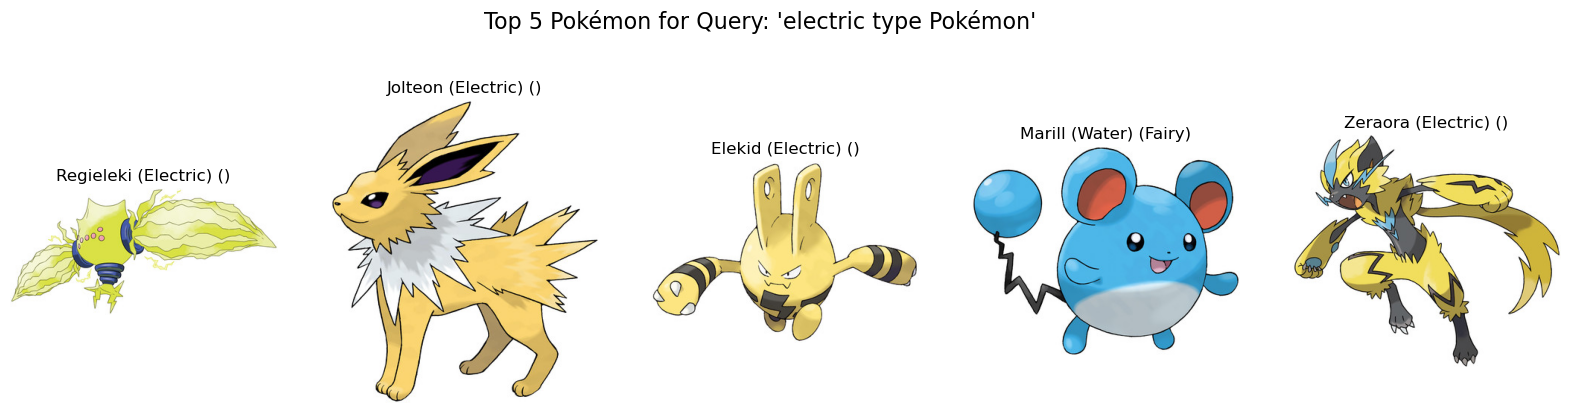

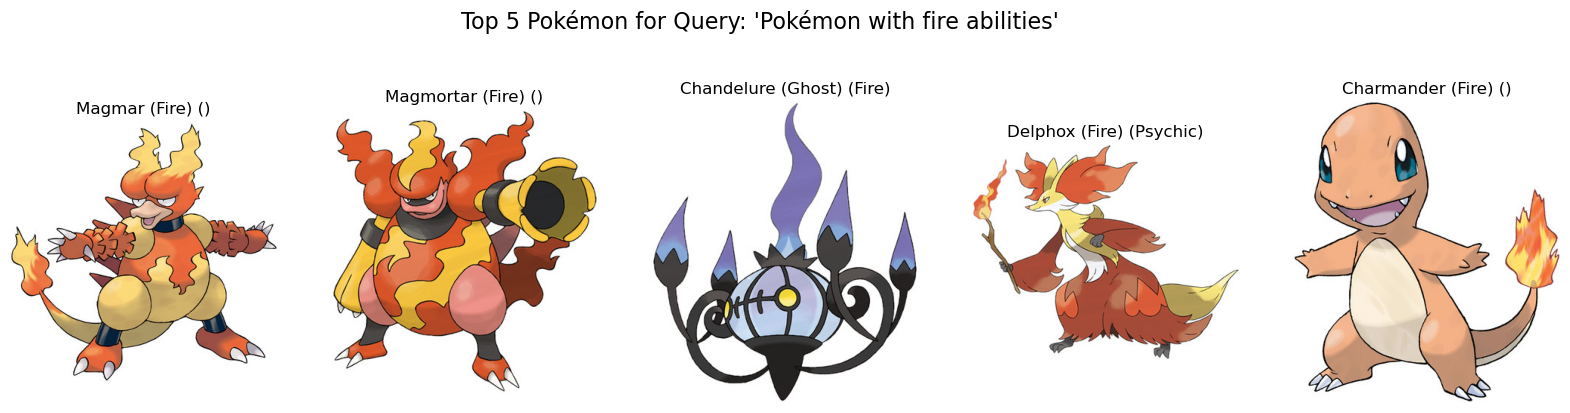

In [37]:

# Function to construct various text queries for Pokémon types
def construct_text_queries():
    queries = [
        "type: Bug",
        "electric type Pokémon",
        "Pokémon with fire abilities"
    ]
    return queries


def find_top_pokemon_for_query(pokedex, model, preprocess, device, query, image_embeddings):
    # Compute text embeddings for the query
    query_embedding = clip_inference_text(model, preprocess, [query], device)[0]
    
    # Compute similarity of query to each Pokémon's image
    image_similarity_scores = compute_similarity_text_to_image(image_embeddings, query_embedding)
    
    # Find indices of top five most relevant Pokémon based on image
    image_top_indices = np.argsort(image_similarity_scores)[-5:][::-1]
    
    # Return the top five most relevant Pokémon from the Pokedex based on image
    top_pokemon_df = pokedex.iloc[image_top_indices].copy()  # Using image similarity for top Pokémon selection
    
    return top_pokemon_df



# Function to plot the top five most relevant Pokémon images for a given query
def plot_top_pokemon_images(top_pokemon_df, query):
    plt.figure(figsize=(20, 5))
    j = 1
    for i, row in top_pokemon_df.iterrows():
        img = Image.open(row["image_path"])
        plt.subplot(1, 5, j)
        j += 1
        plt.imshow(img)
        plt.title(f"{row['Name']} ({row['Type1']}) ({row['Type2']})")
        plt.axis("off")
    plt.suptitle(f"Top 5 Pokémon for Query: '{query}'", fontsize=16)
    plt.show()

# Main function to execute text queries and plot the results
def main():
    
    # Construct text queries
    queries = construct_text_queries()
    
    # Execute queries and plot results
    for query in queries:
        top_pokemon_df = find_top_pokemon_for_query(pokedex, model, preprocess, device, query, image_embeddings)
        plot_top_pokemon_images(top_pokemon_df, query)


main()


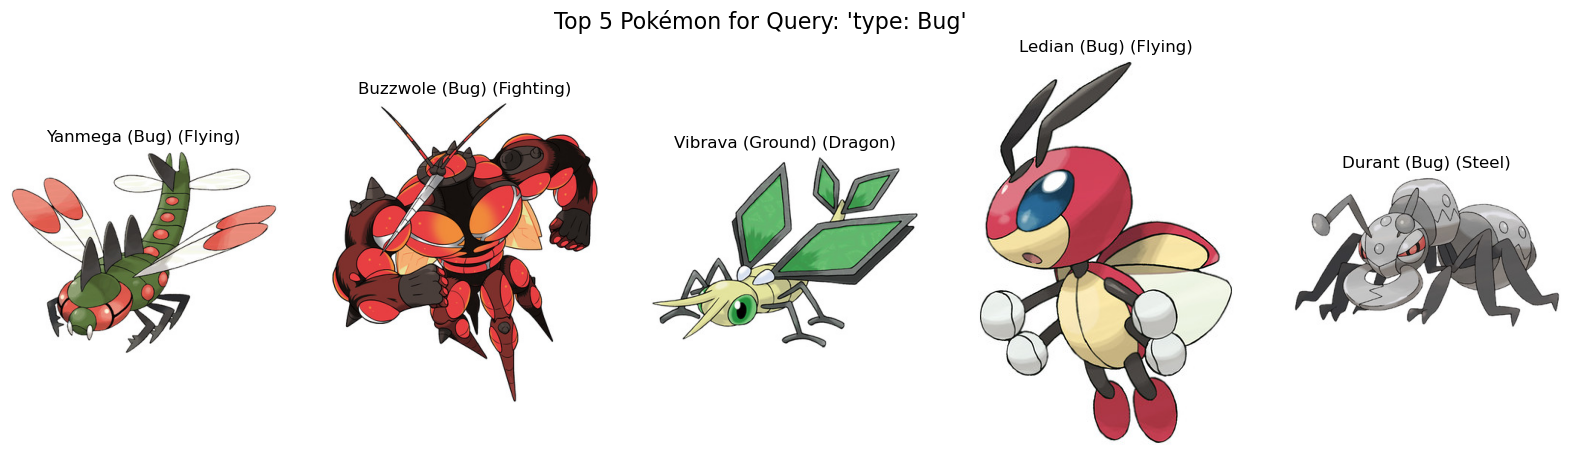

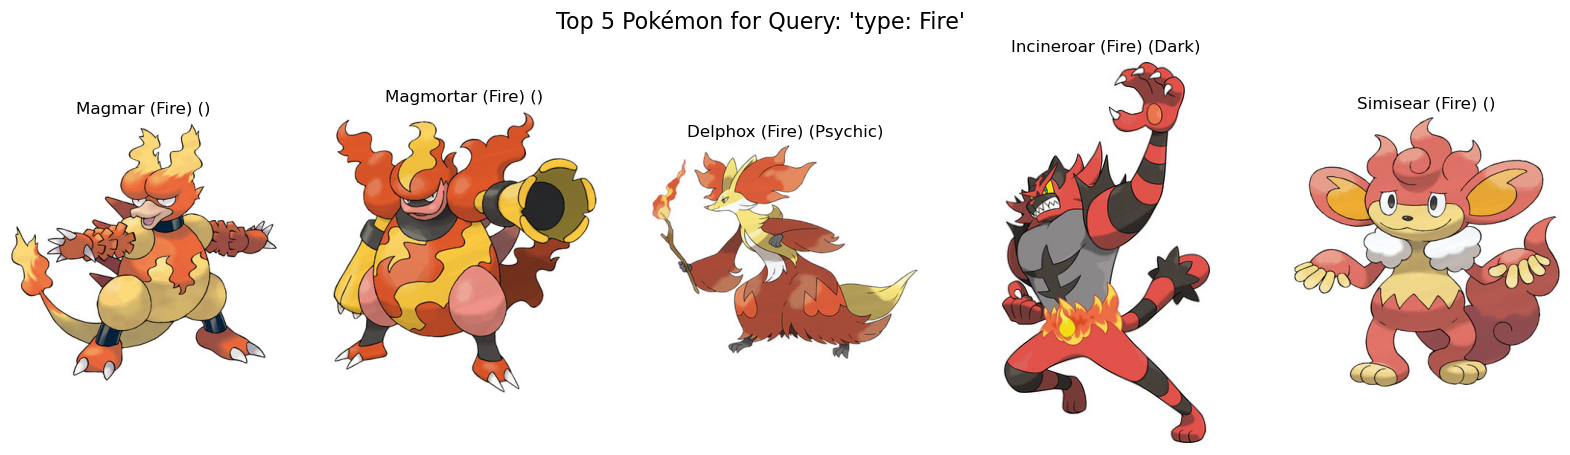

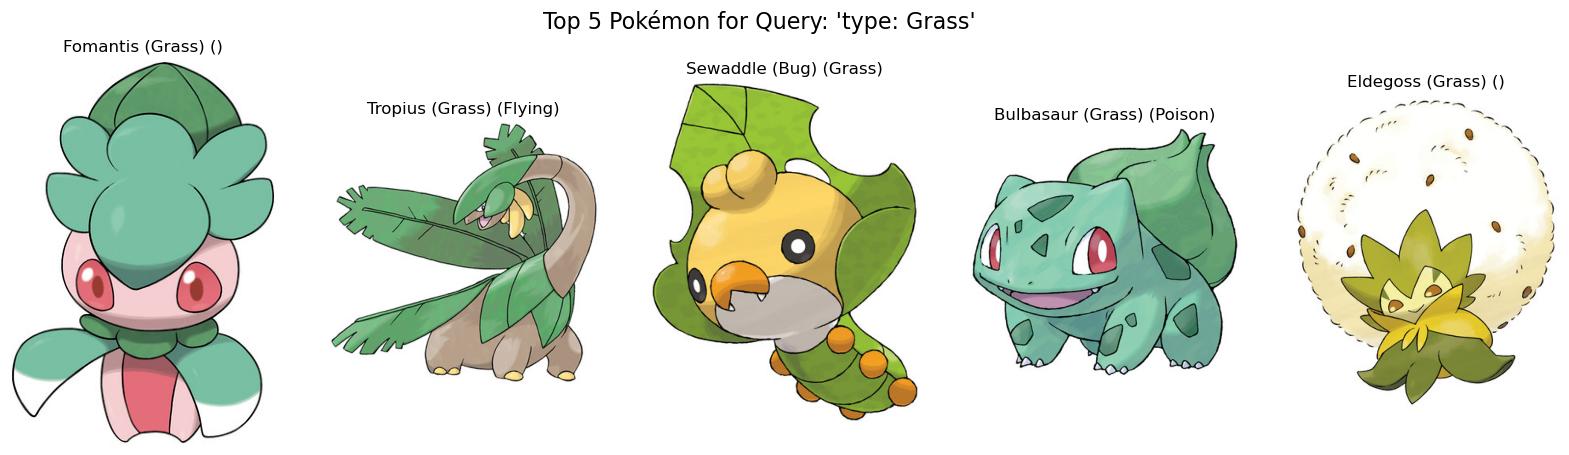

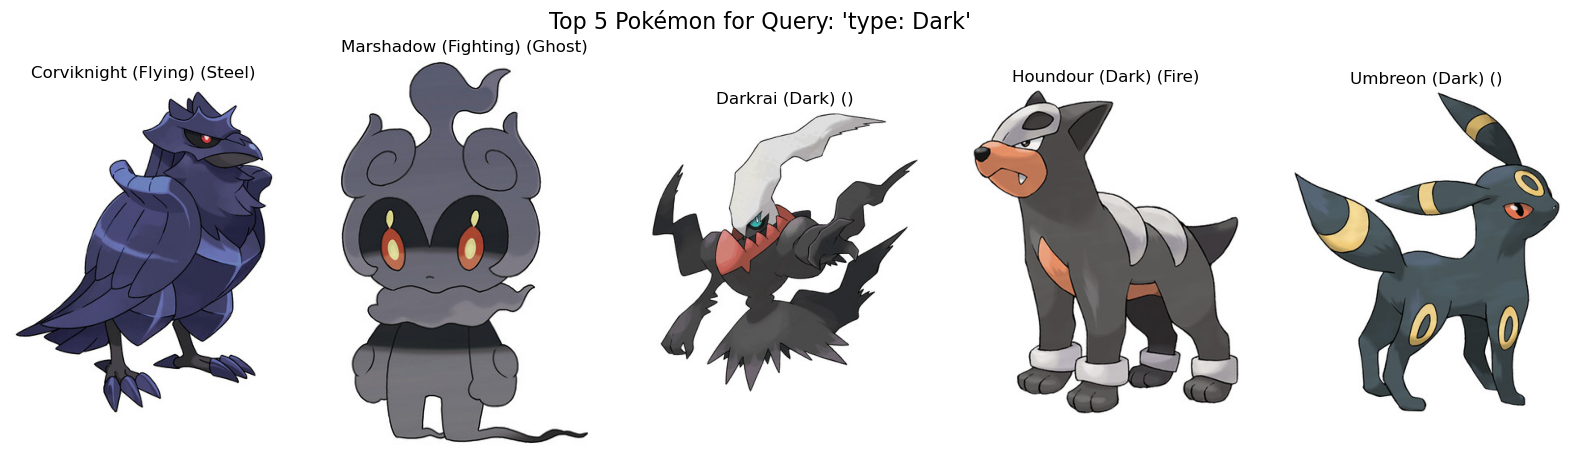

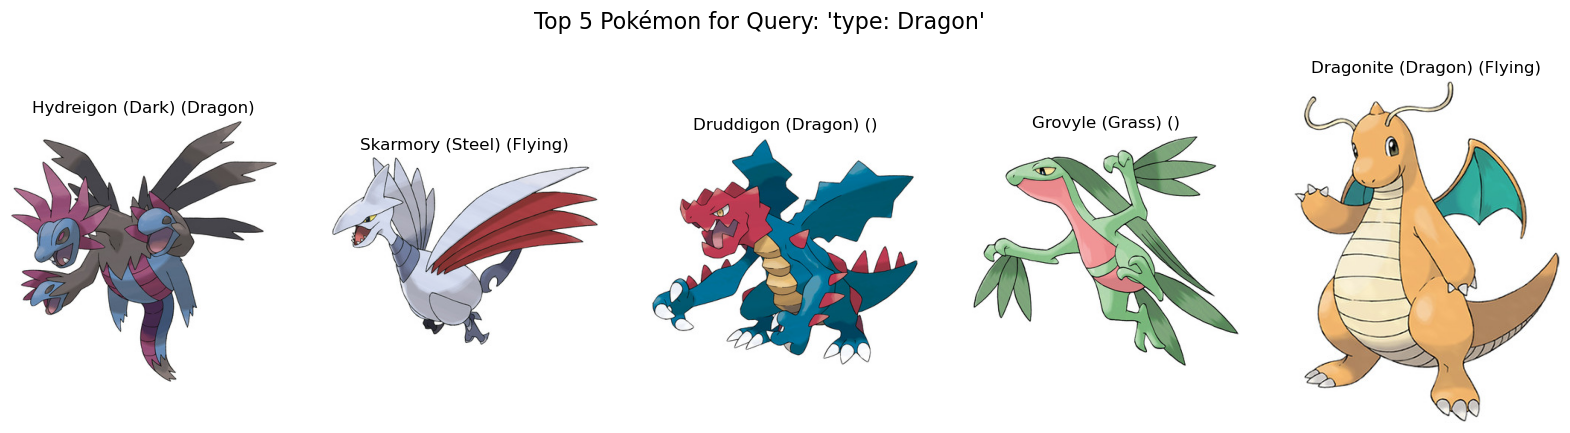

In [38]:
def construct_text_queries():
    queries = [
        "type: Bug",
        "type: Fire",
        "type: Grass",
        "type: Dark",
        "type: Dragon"
    ]
    return queries

main()


All five selection for 'fire' and 'grass' types match with the actual type. There is one mismatch for 'bug' type, namely Vibrava which hase types of 'Ground' and 'Dragon', none of them of type bug.

For the 'Dark' and 'Dragon' type there are two mismatches. First two selected image in each case does not belong to the desired type. However, as can seen from the images, the first two images have the characteristics of target type. For instance, 'Corviknight' and 'Marshadow' both has dark color making them top candidate. Also, 'Hydreigon' and 'skarmory' both have resembelence to dragon shape although they lack 'dragon' in their types.

### Question 27


100%|█████████████████████████████████████████| 754/754 [09:08<00:00,  1.38it/s]


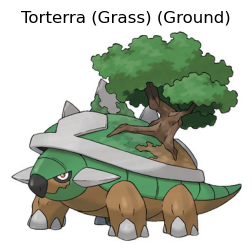

The five most relevant types predicted by CLIP and their predicted probabilities are:
Type: Grass Steel | Probability: 0.0508
Type: Grass Steel | Probability: 0.0508
Type: Grass Steel | Probability: 0.0508
Type: Grass Dragon | Probability: 0.0158
Type: Grass Dragon | Probability: 0.0158


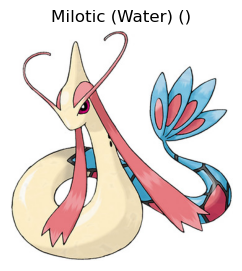

The five most relevant types predicted by CLIP and their predicted probabilities are:
Type: Water Dragon | Probability: 0.0784
Type: Water Dragon | Probability: 0.0784
Type: Water Poison | Probability: 0.0310
Type: Water Poison | Probability: 0.0310
Type: Water Psychic | Probability: 0.0148


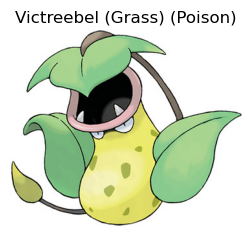

The five most relevant types predicted by CLIP and their predicted probabilities are:
Type: Grass Poison | Probability: 0.0451
Type: Grass Poison | Probability: 0.0451
Type: Grass Poison | Probability: 0.0451
Type: Grass Poison | Probability: 0.0451
Type: Grass Poison | Probability: 0.0451


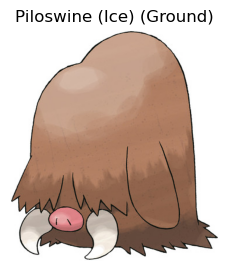

The five most relevant types predicted by CLIP and their predicted probabilities are:
Type: Normal Psychic | Probability: 0.0579
Type: Normal Psychic | Probability: 0.0579
Type: Rock Psychic | Probability: 0.0298
Type: Rock Psychic | Probability: 0.0298
Type: Grass Psychic | Probability: 0.0248


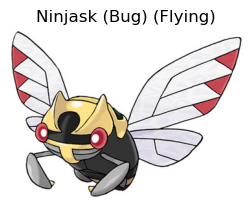

The five most relevant types predicted by CLIP and their predicted probabilities are:
Type: Bug Psychic | Probability: 0.1845
Type: Bug Psychic | Probability: 0.1845
Type: Bug Electric | Probability: 0.0239
Type: Bug Electric | Probability: 0.0239
Type: Bug Electric | Probability: 0.0239


In [52]:
def find_top_type_for_image(pokedex, model, preprocess, device, image_id, type_embeddings):
    # image embeddings for the image_id
    image_embedding = image_embeddings[image_id, :]
    
    # compute similarity of iamge to each type
    type_similarity_scores = compute_similarity_image_to_text(image_embedding, type_embeddings)
    
    # Find indice of top five most relevant Pokémon based on type
    type_top_indices = np.argsort(type_similarity_scores)[-5:][::-1]
    
    # Return the top five most relevant Pokémon from the Pokedex based on image
    top_pokemon_df = pokedex.iloc[type_top_indices].copy()  # Using image similarity for top Pokémon selection
    # probs
    probs = [type_similarity_scores[i] for i in type_top_indices]
    
    return top_pokemon_df, probs


# Function to print tope five most relevant type Pokémon for any random image 
def plot_pokemon_top_types(poke_image_id, top_pokemon_df, probs):
    
    plt.figure(figsize=(3, 3))
    img = Image.open(pokedex.iloc[poke_image_id]["image_path"])
    plt.imshow(img)
    plt.title(f"{pokedex.iloc[poke_image_id]['Name']} ({pokedex.iloc[poke_image_id]['Type1']}) ({pokedex.iloc[poke_image_id]['Type2']})")
    plt.axis("off")
    plt.show()
    print('The five most relevant types predicted by CLIP and their predicted probabilities are:')
    for i in range(top_pokemon_df.shape[0]):
        print(f"Type: {top_pokemon_df.iloc[i]['Type1']} {top_pokemon_df.iloc[i]['Type2']} | Probability: {probs[i]:.4f}")

        
# Main function to randomly select image and assing five most relavant type
def main():   
    # randomly select 10 pokemon images
    image_ids = np.random.randint(0, pokedex.shape[0], 5)

    # Execute queries and plot results
    for image_id in image_ids:
        top_pokemon_df, probs = find_top_type_for_image(pokedex, model, preprocess, device, image_id, type_embeddings)
        plot_pokemon_top_types(image_id, top_pokemon_df, probs)

# # Load Pokedex and CLIP model
# pokedex = construct_pokedex()
# model, preprocess, device = load_clip_model()

main()


### QUESTION 28:
In the first and second question, we investigated how CLIP creates ’clusters’ by mapping images and texts of various Pokemon into a high-dimensional space and explored neighborhood of these items in this space. For this question, please use t-SNE to visualize image clusters, specifically for Pokemon types Bug, Fire, and Grass. 

You can use scatter plot from python package plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’ argument, and label each point with the Pokemon’s name and types using ’hover name’. This will enable you to identify each Pokemon represented in your visualization. 


In [ ]:
# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [5]:
# Pokemon types Bug, Fire, and Grass. 
types_to_filter = ['Bug', 'Fire', 'Grass']
filtered_pokedex = pokedex[pokedex['Type1'].isin(types_to_filter)]

model, preprocess, device = load_clip_model()

 
pokemon_names = filtered_pokedex['Name'].tolist()
type_1 = filtered_pokedex['Type1'].tolist()
type_2 = filtered_pokedex['Type2'].tolist()


In [6]:
filtered_image_embedding  = clip_inference_image(model, preprocess, filtered_pokedex["image_path"].tolist(), device)

tsne_embeddings = umap_projection(filtered_image_embedding)

100%|█████████████████████████████████████████| 192/192 [02:03<00:00,  1.55it/s]


In [18]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(tsne_embeddings, columns=['Component 1', 'Component 2'])
plot_data['Name'] = pokemon_names
plot_data['Type1'] = type_1
plot_data['Type2'] = type_2

plot_data['Name_type'] = 'Name: '+ plot_data['Name'] +' Type1:'+ plot_data['Type1'] +' Type2:'+ plot_data['Type2']

# Plot using Plotly Express scatter plot
fig = px.scatter(plot_data, x='Component 1', y='Component 2', color='Type1', hover_name='Name_type',
                 title='t-SNE Visualization of Pokemon Types (Bug, Fire, Grass)',
                 labels={'Type1': 'Type'})
fig.show()

<font color='red'>After completing the visualization, analyze it and discuss whether the clustering of Pokemon types make sense to you.
    
As seen in the above plot, three types of pokemon are forming distinct groups after being mapped to the space of two most informative component using TSNE, indicating that Pokemon within the same type category share similar visual characteristics captured by the image embeddings. There are some examples which do not conform to the region they fall in and upon inspection it can be seen some of them have the same type2 of the region they have fallen.